In [1]:
%matplotlib inline

import numpy as np
import os
import cv2
import time
import random
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from dataset import tuSimpleDataset
from torch.utils.data import DataLoader
from model import SegNet
import torch.nn.functional as F

In [2]:
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [3]:
# refer from : https://github.com/nyoki-mtl/pytorch-discriminative-loss/blob/master/src/utils.py
def coloring(mask):
    ins_color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    n_ins = len(np.unique(mask)) - 1
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_ins)]
    for i in range(n_ins):
        ins_color_img[mask == i + 1] =\
            (np.array(colors[i][:3]) * 255).astype(np.uint8)
    return ins_color_img

In [4]:
def gen_instance_mask(sem_pred, ins_pred, n_obj):
    embeddings = ins_pred[:, sem_pred].transpose(1, 0)
#     clustering = KMeans(n_obj).fit(embeddings)
    clustering = DBSCAN(eps=0.1).fit(embeddings)
    labels = clustering.labels_

    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(n_obj):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl

    return instance_mask

In [5]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 2
BATCH_SIZE = 20
SIZE = [224, 224]

In [6]:
train_path = '/data/tuSimple/train_set/'
test_path = '/data/tuSimple/test_set/'
MODEL_PATH = '../model_best.pth'

In [7]:
test_dataset = tuSimpleDataset(test_path, size=SIZE, train=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [8]:
model = SegNet(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
model.load_state_dict(torch.load(MODEL_PATH))

In [9]:
model.eval()
imgs = next(iter(test_dataloader))

In [10]:
input_tensor = torch.autograd.Variable(imgs).cuda()
sem_pred_, ins_pred_ = model(input_tensor)

In [11]:
input_tensor.size(), sem_pred_.size(), ins_pred_.size()

(torch.Size([20, 3, 224, 224]),
 torch.Size([20, 2, 224, 224]),
 torch.Size([20, 5, 224, 224]))

In [12]:
input_tensor.max(), sem_pred_.max(), ins_pred_.max()

(tensor(255., device='cuda:0'),
 tensor(34.6077, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.4819, device='cuda:0', grad_fn=<MaxBackward1>))

In [13]:
images = input_tensor.permute(0,2,3,1).contiguous().cpu().data.numpy()
images = np.array(images, dtype=np.uint8)

In [14]:
sem_pred = sem_pred_[:,1,:,:].cpu().data.numpy()
ins_pred = ins_pred_.cpu().data.numpy()

In [15]:
images.shape, sem_pred.shape, ins_pred.shape

((20, 224, 224, 3), (20, 224, 224), (20, 5, 224, 224))

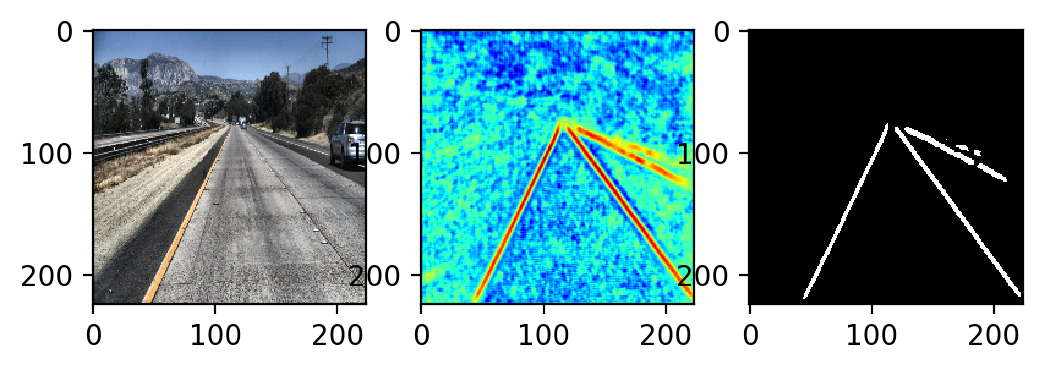

In [16]:
p_sem_pred = []
for sp in sem_pred:
    p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

plt.figure(dpi=200)
plt.subplot(131);plt.imshow(images[0])
plt.subplot(132);plt.imshow(sem_pred[0],'jet')
plt.subplot(133);plt.imshow(p_sem_pred[0], 'gray')

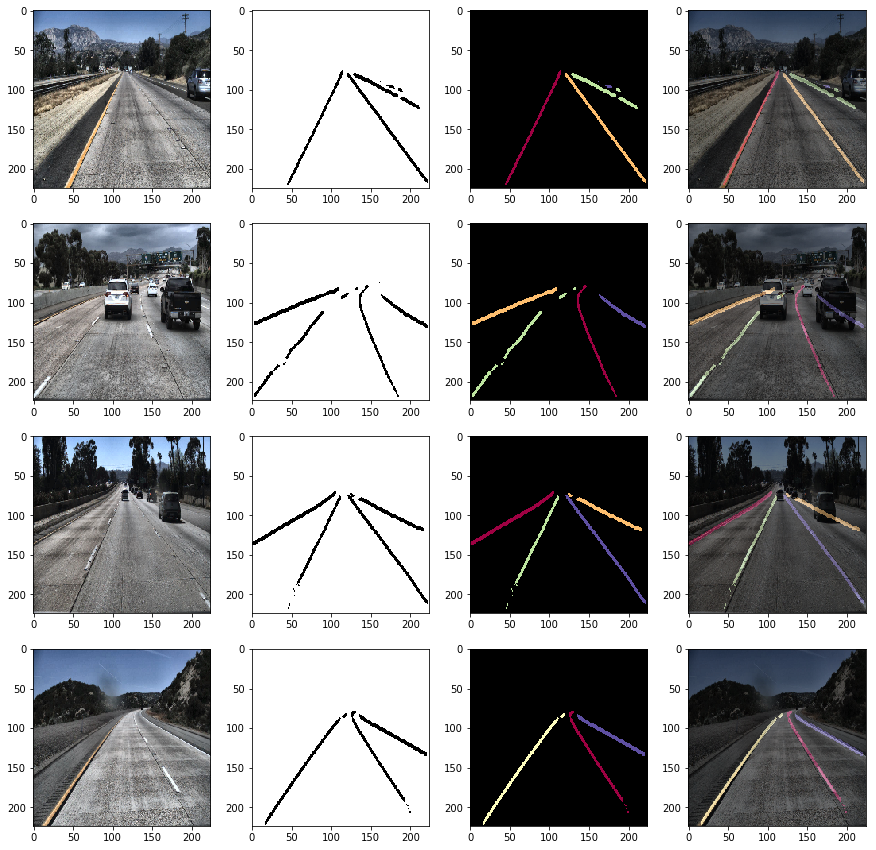

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
plt.gray()

for i, ax_ in enumerate(axes):
    color_img = coloring(gen_instance_mask(p_sem_pred[i], ins_pred[i], 8))
    ax_[0].imshow(images[i])
    ax_[1].imshow(~p_sem_pred[i])
    ax_[2].imshow(color_img)
    ax_[3].imshow(cv2.addWeighted(images[i], 0.5, color_img, 0.5, 0))